In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import scale

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

from xgboost.sklearn import XGBRegressor
import xgboost as xgb

import math

In [29]:
commercial_merged_dataset = pd.read_csv("commercial_regression_new_with_solar.csv")

In [30]:
commercial_merged_dataset.columns

Index(['Year', 'Month', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL',
       'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV',
       'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA',
       'VT', 'WA', 'WI', 'WV', 'WY', 'Retail Price(Cents/kWh)', 'CLDD', 'TAVG',
       'AWND', 'HTDD', 'area', 'population', 'solar-generation', 'Spring',
       'Summer', 'Fall', 'Winter', 'mkwh', 'Generation(mwh)'],
      dtype='object')

In [31]:
pa_commercial_data = commercial_merged_dataset.loc[commercial_merged_dataset['PA'] == 1]


In [32]:
pa_commercial_data = pa_commercial_data.drop(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL',
       'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV',
       'NY', 'OH', 'OK', 'OR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA',
       'VT', 'WA', 'WI', 'WV', 'WY'], axis=1)
pa_commercial_data

,Year,Month,PA,Retail Price(Cents/kWh),CLDD,TAVG,AWND,HTDD,area,population,solar-generation,Spring,Summer,Fall,Winter,mkwh,Generation(mwh)
37,2014,1,1,10.43,0.000000,20.140602,8.033333,1382.917293,46055,12788313,7,0,0,0,1,3894,20428268.87
87,2014,2,1,10.53,0.000000,23.232520,7.142308,1161.073171,46055,12788022,7,0,0,0,1,3712,18811217.37
137,2014,3,1,10.09,0.000000,30.912950,8.615385,1048.841727,46055,12787732,10,1,0,0,0,3680,18791215.70
187,2014,4,1,9.62,3.820144,48.134532,8.450000,507.323741,46055,12787441,10,1,0,0,0,3337,17065799.41
237,2014,5,1,9.41,34.808511,59.490780,6.353846,204.695035,46055,12787151,11,1,0,0,0,3361,16941485.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3387,2019,8,1,8.49,192.609023,70.703008,4.780000,16.639098,46055,12802611,17,0,1,0,0,3569,21731512.00
3437,2019,9,1,8.50,88.030534,66.169466,5.052000,53.175573,46055,12802700,14,0,0,1,0,3375,19297955.00
3487,2019,10,1,8.63,21.700787,54.696850,6.572000,339.464567,46055,12802789,12,0,0,1,0,3102,17659006.00
3537,2019,11,1,8.88,0.000000,37.236800,7.148000,825.040000,46055,12802878,9,0,0,1,0,2881,18232579.00


In [33]:
numeric_feature_name = ['Retail Price(Cents/kWh)','CLDD', 'TAVG', 'area', 'AWND', 'HTDD', 
                        'population', 'solar-generation']

categorical_feature_name = ['Year', 'Month', 'Spring', 'Summer', 'Fall', 'Winter']

# fetch the respective numeric, categorical and output values
commercial_numeric_features = pd.DataFrame(pa_commercial_data[numeric_feature_name])
commercial_categorical_features = pd.DataFrame(pa_commercial_data[categorical_feature_name])
commercial_y_val = pd.DataFrame(pa_commercial_data['mkwh'])

# reindex the unscaled dataframes to simplify the concatenation
commercial_categorical_features = commercial_categorical_features.reset_index(drop=True)
commercial_y_val = commercial_y_val.reset_index(drop=True)

In [34]:
# use min_max scaler to scale data
# max_abs_scaler = preprocessing.MaxAbsScaler()
max_abs_scaler = preprocessing.MaxAbsScaler()
commercial_numeric_minmax = max_abs_scaler.fit_transform(commercial_numeric_features)

In [35]:
df_commercial_numeric = pd.DataFrame(commercial_numeric_minmax, columns=numeric_feature_name)


In [36]:
# concatenate the new numeric value and the categorical value
df_commercial_train = pd.concat([commercial_categorical_features, df_commercial_numeric, commercial_y_val], axis=1)



In [10]:
# the input into the regression function
regr_commercial = df_commercial_train.drop(['Year', 'Month', 'Spring'],axis = 1)


In [11]:
#Train-Test Split
train, test = train_test_split(regr_commercial, test_size=0.2)

X_train = train.drop(['mkwh'],axis = 1)
y_train = train['mkwh']
X_test = test.drop(['mkwh'],axis = 1)
y_test = test['mkwh']

In [ ]:
y_train

In [12]:
def evaluate_performances(y_test, y_pred):
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, y_pred)))

In [13]:
#Visualize the output

def visualize_graph(df_pred):
    fig, axes = plt.subplots(3,1, figsize=(7,15))
    #Plot the result in box plot
    df_pred.plot(title="Actual vs. Predict result box plot",kind='box',ax=axes[0])
    #Plot the scatter plot 
    df_pred.plot.scatter(title="Actual vs. Predict result scatter plot",  x='Actual',y='Predicted', c='DarkBlue',ax=axes[1])
    #Plot the result in terms of kernel density estimation
    df_pred.plot(title="Actual vs. Predict result kernel density estimation", kind='density',ax=axes[2])

In [14]:
K = 5
model = XGBRegressor(objective ='reg:squarederror')
scores = cross_val_score(model, X_train, y_train, cv=K, scoring='neg_mean_squared_error', verbose=False)
avg_rmse = math.sqrt(abs(np.mean(scores)))

print('Average RMSE with {}-fold Cross Validation: {:.3f}'.format(K, avg_rmse))

Average RMSE with 5-fold Cross Validation: 116.445


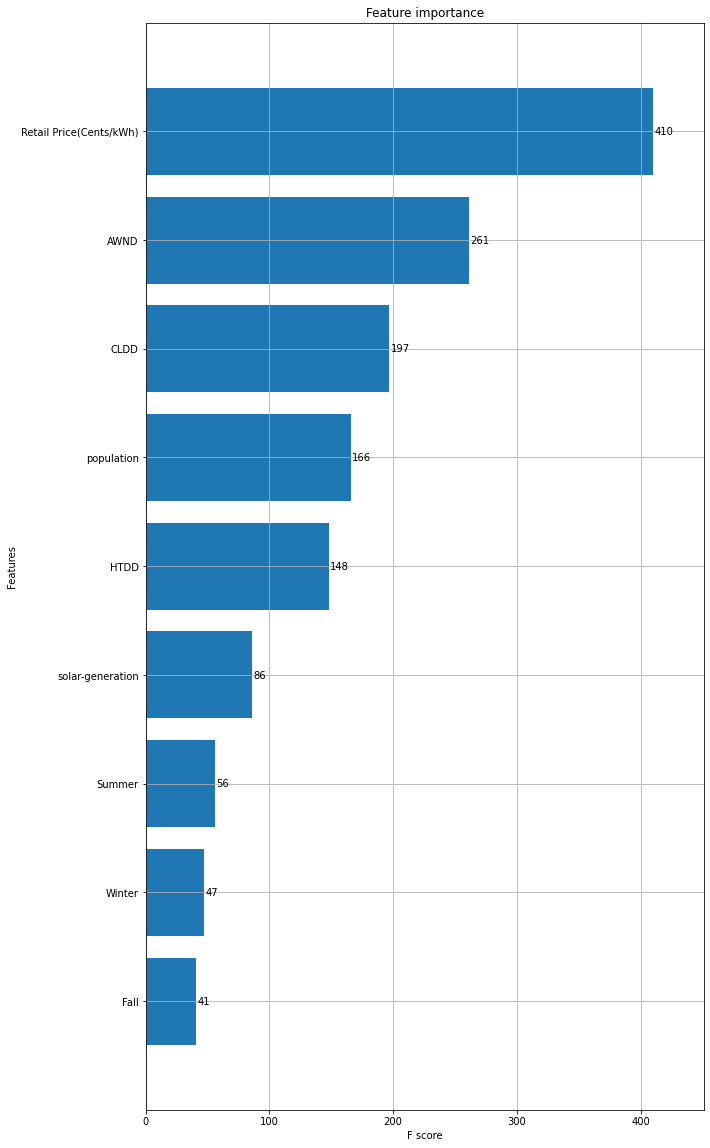

In [15]:
model = XGBRegressor(objective ='reg:squarederror')
model.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(10,20))
xgb.plot_importance(model, height=0.8, ax=ax)

In [16]:
def sm_regression(X_train,y_train,X_test,y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train,X_train)
    results = model.fit()
    results.params
    print(results.summary())
    predictions = results.predict(X_test)
    df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
    
    return df_pred

In [17]:
sm_regression(X_train, y_train, X_test, y_test)

                            OLS Regression Results                            
Dep. Variable:                   mkwh   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     20.97
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           1.23e-13
Time:                        12:29:01   Log-Likelihood:                -345.03
No. Observations:                  57   AIC:                             710.1
Df Residuals:                      47   BIC:                             730.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1

,Actual,Predicted
46,3322,3472.874759
36,3745,3631.585865
52,3375,3424.060366
30,3924,4193.604094
22,3329,3498.334893
12,3826,3798.871665
66,3408,4150.899136
5,3650,3658.346055
71,3092,3542.545451
38,3539,3481.588486


Mean Absolute Error: 215.5343495979653
Mean Squared Error: 92342.39217748676
Root Mean Squared Error: 303.87891038617136


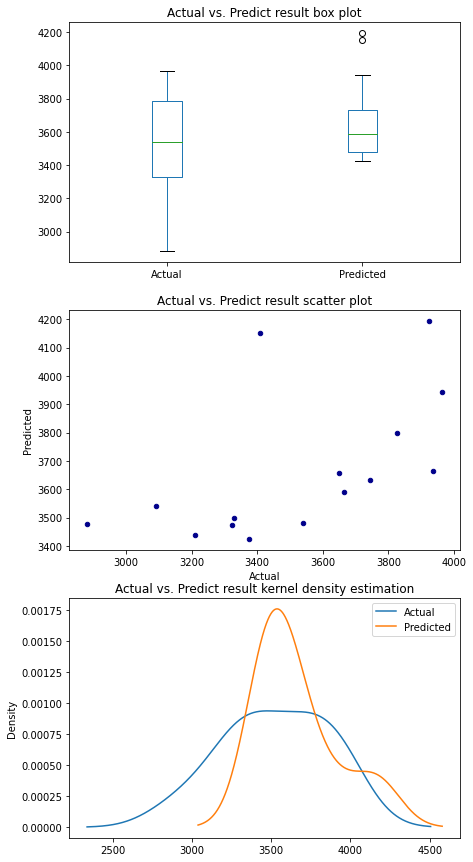

In [18]:
com_lr = LinearRegression()
com_lr.fit(X_train, y_train)
com_predictions = com_lr.predict(X_test)
evaluate_performances(y_test, com_predictions)
com_df_pred = pd.DataFrame({'Actual': y_test, 'Predicted': com_predictions})
visualize_graph(com_df_pred)

In [37]:
def cal_vif(df):
    features= df[['Retail Price(Cents/kWh)', 'TAVG', 'area', 'CLDD', 'AWND', 'HTDD', 'population']]
    X = add_constant(features)
    vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    
    return vif

In [38]:
cal_vif(df_commercial_train)

Retail Price(Cents/kWh)    2.876084e+00
TAVG                       4.302090e+02
area                       7.114711e+06
CLDD                       1.399268e+01
AWND                       3.787500e+00
HTDD                       3.235793e+02
population                 2.416940e+00
dtype: float64

In [21]:
a  = com_lr.intercept_#截距
b = com_lr.coef_#回归系数
print("最佳拟合线:截距",a,",回归系数：",b)

最佳拟合线:截距 123634.85829736857 ,回归系数： [-4.08751299e+01  2.57026589e+01 -7.78304109e+00 -1.46940316e+01
  1.03734098e+03 -6.06635140e+02  8.62772103e+02 -1.20312374e+05
  1.44551755e+02]


In [22]:
# Visualization
def visualization(y_pred):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30,20))
    fig.suptitle('Predicted and Actual plot')
    ax1.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax1.legend(loc="upper right")
    ax2.plot(range(len(y_pred)),y_pred,'r',label="actual")
    ax2.legend(loc="upper right")
    ax3.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax3.plot(range(len(y_pred)),y_test,'r',label="test")
    ax3.legend(loc="upper right")
    plt.show()

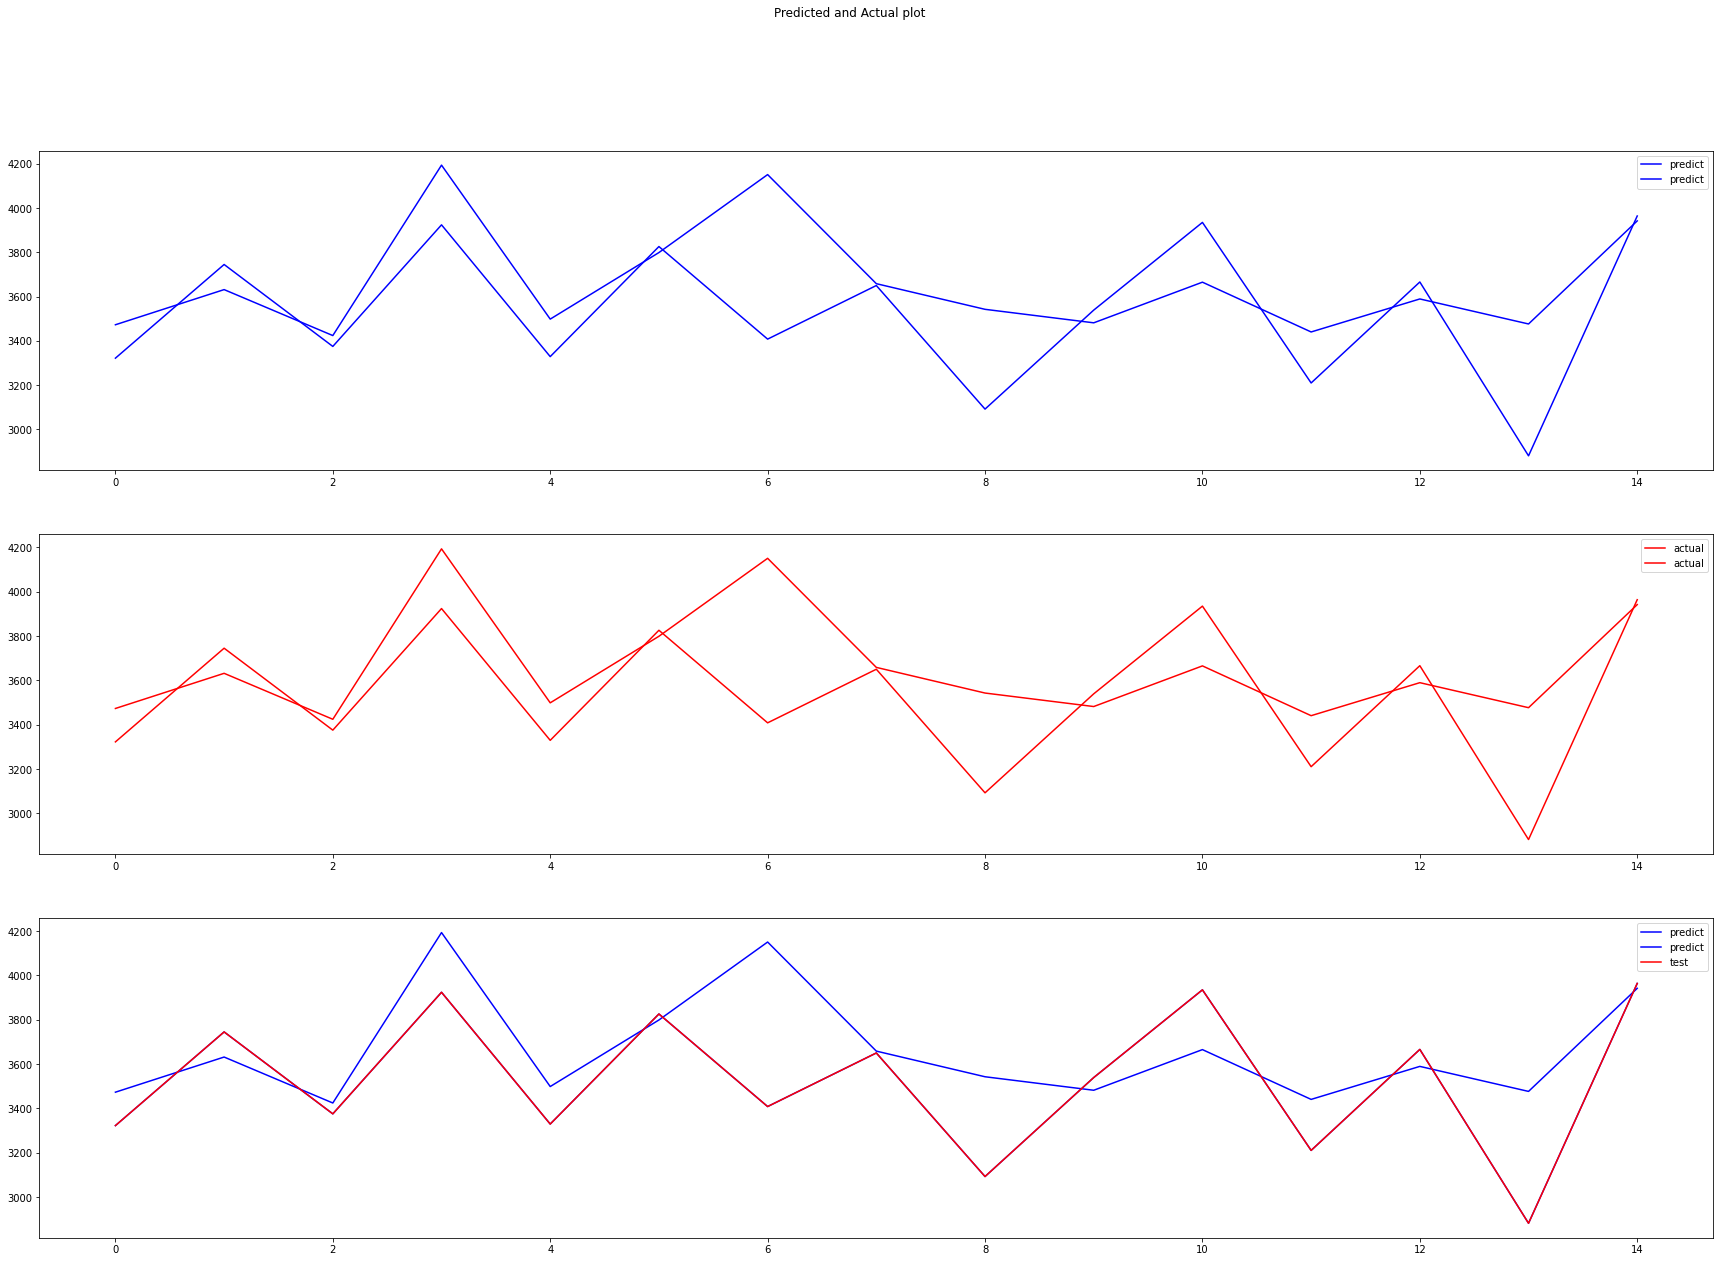

In [23]:
visualization(com_df_pred)